In [196]:
!cd Pic_t && rm -rf ./*

In [197]:
import numpy as np
from scipy.stats import norm

from tqdm import trange
from tqdm import tqdm
from time import sleep

from IPython.display import Image

from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
plt.style.use('seaborn-pastel')

/tmp/ipykernel_1368/4083207405.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-pastel')


In [198]:
file_1 = np.load('IC_100N101dte5add100_003.npz')

In [199]:
pos,vel,mass=file_1["pos"],file_1["vel"],file_1["mass"]

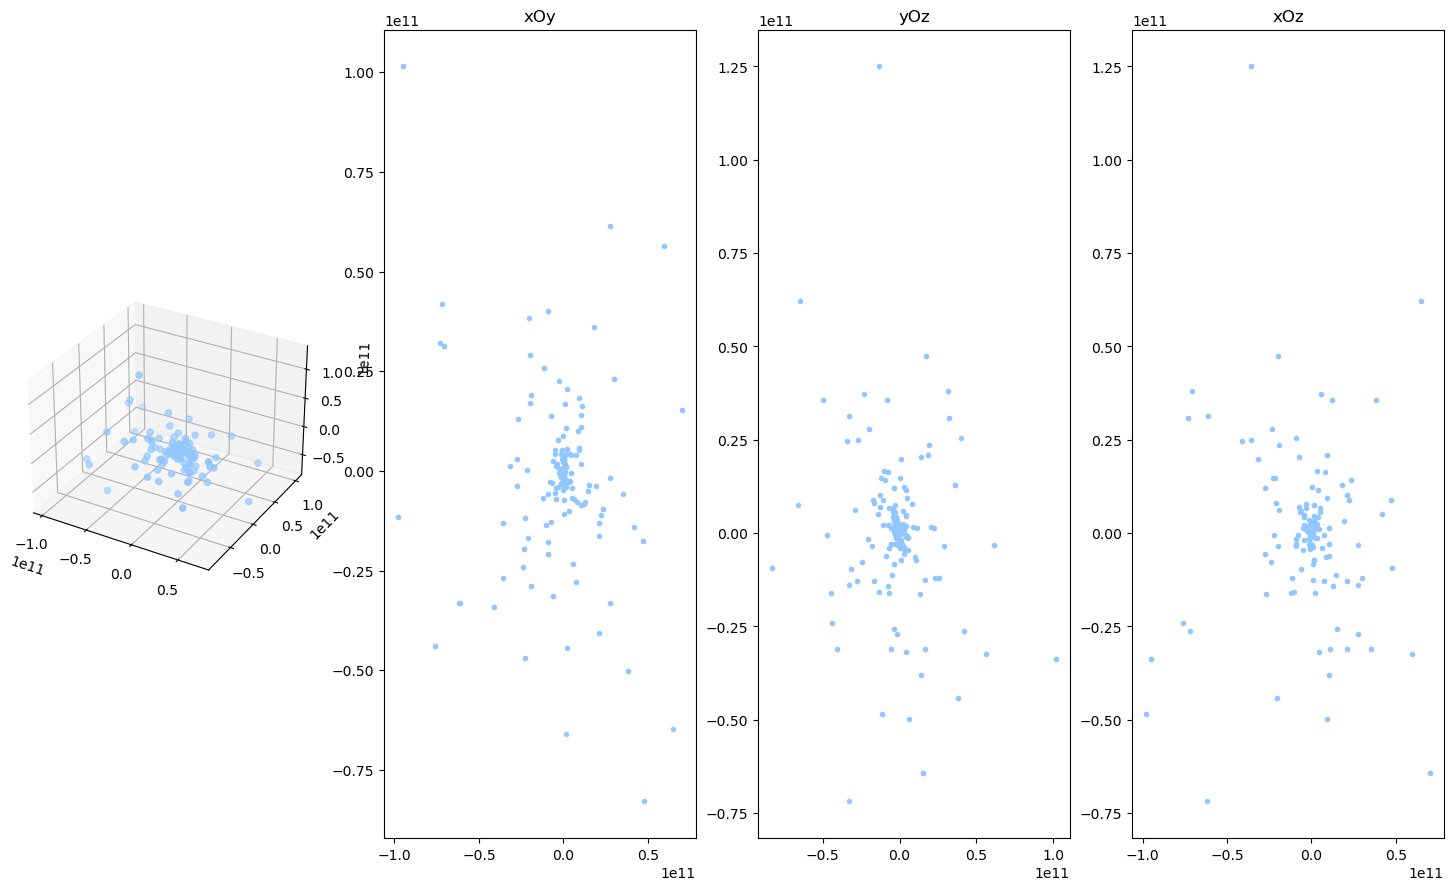

In [200]:
figx = plt.figure()
figx.set_size_inches(18.5, 10.5)
axx = figx.add_subplot(141,projection='3d')
axx.scatter(pos[:,0],pos[:,1],pos[:,2])
axx2=figx.add_subplot(142,title="xOy")
axx2.plot(pos[:,0],pos[:,1],".")
axx3=figx.add_subplot(143,title="yOz")
axx3.plot(pos[:,1],pos[:,2],".")
axx4=figx.add_subplot(144,title="xOz")
axx4.plot(pos[:,0],pos[:,2],".")
plt.show()

In [201]:
M_cl=np.sum(mass[:-1]) # small claster BH mass in M⊙ # 3.1/100 M⊙ was last time all works
mbig= mass[-1][0] # big central BH mass in Msol  # 10**6 # 30 M⊙ was last time all works

G = 3.086*10**13/233   # Newton's Gravitational Constant # km⋅M⊙−1⋅(km/s)**2
n100=len(mass[:-1]) # number of small BH in claster
R_cl= 3.086*10**10#1.496e+10 # approx 1 a.u. # 4*10**10 km was last time all works #  R_claster in km

# Time relacsation -- not precise anough, but for some reason its works in dif range of parameters
T_rel=n100/(25.5*np.log10(n100/2))*np.sqrt(R_cl**(3)/(G*M_cl))  # propocional R_cl**(3/2) 
a= 10*R_cl # Semi-major axsis # last times we try: 0.0025 * 3.086*10**13 # a = 0.01 pc
e=0. # Eccentricity # last 0.997
# Velosity in apoapsis or anywhere in round case
v_e= np.sqrt(G* (2*mbig+2*M_cl)*(1-e)/(a*(1+e)))
# Period of double system:
T=2*np.pi*a/v_e # propocional a**(3/2)
print(f"a= {a:.3}, e= {e:.3f}, T_rel= {T_rel:.2}, V_e= {v_e:.2}, T= {T:.2} ")

n101=n100+1
T_rel=n101/(25.5*np.log10(n101/2))*np.sqrt(R_cl**(3)/(G*(M_cl+mbig))) 
print(f"a= {a:.3}, e= {e:.3f}, T_rel= {T_rel:.2}, V_e= {v_e:.2}, T= {T:.2} ")

"""
Create Your Own N-body Simulation (With Python)
Philip Mocz (2020) Princeton Univeristy, @PMocz
Simulate orbits of stars interacting due to gravity
Code calculates pairwise forces according to Newton's Law of Gravity
"""
""" N-body simulation """
# Simulation parameters
N = n101#1 202  # Number of particles
N_c1=n100
t = 0      # current time of the simulation
tEnd = T # time at which simulation ends
dt = 10**5  # timestep 000000
softening = 1.e9 #1.e5    # softening length
softening_M = 1.e7
# 1 pc = 3.08*10**13 km
G = 3.086*10**13/233  # approx 4.3009172706*3.086*10**10 # Newton's Gravitational Constant # km⋅M⊙−1⋅(km/s)**2
#plotRealTime = True # switch on for plotting as the simulation goes along
Nt = int(np.ceil(tEnd/dt))
print("time steps: ",Nt)



a= 3.09e+11, e= 0.000, T_rel= 3.8e+09, V_e= 1.5e+01, T= 1.3e+11 
a= 3.09e+11, e= 0.000, T_rel= 3e+09, V_e= 1.5e+01, T= 1.3e+11 
time steps:  1328964


In [202]:

def getKinEn(m,v):
    n=v.shape[0]
    v-=np.ones((n,3))*np.dot(m.T,v)[0]/ np.sum(m)
    return 0.5 *np.sum(np.dot(m.T,v*v))

def mInertia(m,p):
	return np.sum(np.dot(m.T,p*p))
	
### Position coordinat linar distribution of objects in ball-shaped claster

def sqrt_dist(n,pos_0, R=1., soft=1.e8):
    phi = np.random.rand(n) * 2 * np.pi
    r = np.random.uniform(soft,R,n)
    theta = np.arccos(np.random.uniform(-1,1,n))
    return np.array([r * np.sin(theta) * np.cos(phi)+pos_0[0,0], 
		r * np.sin(theta) * np.sin(phi)+pos_0[0,1],r * np.cos(theta)+pos_0[0,2]]).T

### Monte-carlo generator of position coordinat uniform distribution of objects in ball-shaped claster
def MC_cl_pos(n,pos_0, R=1., p=np.random.uniform(0,1,(0,3)), soft=1.e8):
	ip=np.append(p,np.random.uniform(0,R,(n-len(p),3))*np.sign(np.random.randn(n-len(p),3)),axis=0)
	fp=np.delete(ip,np.where(np.array(np.sum(ip**2,axis=1)>R**2)+np.array(np.sum(ip**2,axis=1)<(soft)**2)), axis = 0)
	if not len(fp)-n==0:
		return MC_cl_pos(n, pos_0, R, fp)
	else: 
		return fp+pos_0
	
def getEnergy( pos, mass, G ):
	"""
	Get kinetic energy (KE) and potential energy (PE) of simulation
	pos is N x 3 matrix of positions
	vel is N x 3 matrix of velocities
	mass is an N x 1 vector of masses
	G is Newton's Gravitational constant
	KE is the kinetic energy of the system
	PE is the potential energy of the system
	"""
	# Potential Energy:

	# positions r = [x,y,z] for all particles
	x = pos[:,0:1]
	y = pos[:,1:2]
	z = pos[:,2:3]

	# matrix that stores all pairwise particle separations: r_j - r_i
	dx = x.T - x
	dy = y.T - y
	dz = z.T - z

	# matrix that stores 1/r for all particle pairwise particle separations 
	inv_r = np.sqrt(dx**2 + dy**2 + dz**2+softening*softening)
	inv_r[inv_r>0.] = 1.0/inv_r[inv_r>0]

	# sum over upper triangle, to count each interaction only once
	PE = G * np.sum(np.sum(np.triu(-(mass*mass.T)*inv_r,1)))
	
	return PE;

In [203]:

ind_cl1=np.append(np.arange(0,N_c1),-1)#7 np.append(np.arange(0,N_c1),-2)
#8 ind_cl2= np.append(np.arange(N_c1,2*N_c1),-1)

# Potential Energy:
PE1=getEnergy(pos[ind_cl1],mass[ind_cl1], G )
#9 PE2=getEnergy(pos[ind_cl2],mass[ind_cl2], G )
print("Potential Energy: ",PE1)#10 ,PE2)
print(getEnergy(pos[ind_cl1],mass[ind_cl1], G )/getKinEn(mass[ind_cl1],vel[ind_cl1]) )

Potential Energy:  -408426.9510540524
-2.7317952274101422


In [206]:
vel

array([[-4.42234527e+00, -6.84201173e+00, -9.16520981e+00],
       [ 9.48352473e-01, -2.08661405e+01,  1.31926718e+01],
       [-1.08834156e+01, -1.32597086e+01,  1.53065141e+01],
       [ 2.24063065e+01, -1.42807956e+01,  8.64433961e+00],
       [ 2.00342443e+01, -5.10731848e+00, -8.77022137e+00],
       [ 3.26237771e+01, -2.39734328e+01,  2.94549909e+00],
       [-5.39425423e+01, -1.45522112e+01, -3.47018131e+00],
       [ 1.10723186e+01, -1.89613200e+01, -1.61088543e+01],
       [-6.64671558e+01, -7.27760326e+01,  7.80286976e+00],
       [ 1.35308866e+00, -1.47813070e+01,  2.08361880e+00],
       [-1.86990963e+00, -3.99253696e+00,  1.39742008e+00],
       [-8.37698948e+00, -1.41107479e+01,  9.30776589e+00],
       [-1.96526319e+01,  8.59234860e-01,  6.20153480e+00],
       [ 4.33062036e+00,  3.12155307e-01,  1.32198682e+01],
       [ 1.11032155e+01, -7.39661634e+00, -8.24741683e+00],
       [ 5.15713945e+00,  4.31128097e+01, -3.87942663e+01],
       [-4.98254893e+01, -1.42245001e+01

In [207]:
import numexpr as ne

In [208]:
def getAcc( pos, mass, G, softening ):
  """
    Calculate the acceleration on each particle due to Newton's Law 
	pos  is an N x 3 matrix of positions
	mass is an N x 1 vector of masses
	G is Newton's Gravitational constant
	softening is the softening length
	a is N x 3 matrix of accelerations
"""
  # positions r = [x,y,z] for all particles
  x = pos[:,0:1]
  y = pos[:,1:2]
  z = pos[:,2:3]

  # matrix that stores all pairwise particle separations: r_j - r_i
  dx = x.T - x
  dy = y.T - y
  dz = z.T - z

  # matrix that stores 1/r^3 for all particle pairwise particle separations
  inv_r3 = ne.evaluate("dx*dx + dy*dy + dz*dz + softening*softening") # softening - for halo particles
  #check your distance parameter (if it is too big, than there would be calculation problems)

  #inv_r3_coal=inv_r3[inv_r3==softening*softening]
  inv_r3_pos=inv_r3[inv_r3>0.]
  inv_r3[inv_r3>0.] = ne.evaluate("inv_r3_pos**(-1.5)")

  ax = G * (dx * inv_r3) @ mass
  ay = G * (dy * inv_r3) @ mass
  az = G * (dz * inv_r3) @ mass

	# pack together the acceleration components
  a = np.hstack((ax,ay,az))

  return a

acc=getAcc( pos, mass, G, softening )

In [209]:
#N_T,dN_T,dN_T2,dN_T3 = 1000000,1000,10,1000 #>10 000 000 is not real 
N_T,dN_T,dN_T2,dN_T3 =    50000,1,1,1

def NinShell(inp,pos_cm): #    inp=pos_save[:,:,1]
	pos_in_shell=np.delete(inp, np.where(np.sum((inp-pos_cm)**2,axis=1)>(R_cl)**2), axis = 0)
	return len(pos_in_shell)

def RotEn(m,p,v):
	return (np.sqrt(np.sum(np.cross(p,m*v)**2)))**2/(2*mInertia(m,p))

NinS1=np.zeros((N_T//dN_T3+1))
NinS1[0]=NinShell(pos[ind_cl1],pos[ind_cl1[-1]])
#NinS2=np.zeros((N_T//dN_T3+1))
#NinS2[0]=NinShell(pos[ind_cl2],pos[ind_cl2[-1]])


Ltot1=np.zeros((N_T//dN_T3+1))
Ltot1[0]=np.sqrt(np.sum(np.cross(pos,mass*vel)**2))/(3.086*10**13)
#Ltot1[0]=np.sqrt(np.sum(np.cross(pos[-2:],mass[-2:]*vel[-2:])**2))/(3.086*10**13)
Ltot2=np.zeros((N_T//dN_T3+1))
Ltot2[0]=np.sqrt(np.sum(np.cross(pos[:-1],mass[:-1]*vel[:-1])**2))/(3.086*10**13)
#Ltot2[0]=np.sqrt(np.sum(np.cross(pos[:-2],mass[:-2]*vel[:-2])**2))/(3.086*10**13)

# Energy
E1_save=np.zeros((N_T//dN_T3+1,3))
E1_save[0]=(-getEnergy(pos[ind_cl1],mass[ind_cl1], G ),
	(0.5 * np.sum(np.sum( mass[ind_cl1] * vel[ind_cl1]**2 ))),
	RotEn(mass[ind_cl1],pos[ind_cl1],vel[ind_cl1]))   
#E2_save=np.zeros((N_T//dN_T3+1))
#E2_save[0]=-getEnergy(pos[ind_cl2],mass[ind_cl2], G )+(0.5 * np.sum(np.sum( mass[ind_cl2] * vel[ind_cl2]**2 )))


#Virial
Vir1_save=np.zeros((N_T//dN_T3+1))
Vir1_save[0]=-getEnergy(pos[ind_cl1],mass[ind_cl1], G )/getKinEn(mass[ind_cl1],vel[ind_cl1])     
#Vir2_save=np.zeros((N_T//dN_T3+1))
#Vir2_save[0]=-getEnergy(pos[ind_cl2],mass[ind_cl2], G )/getKinEn(mass[ind_cl2],vel[ind_cl2])




# calculate initial gravitational accelerations
  
# number of timesteps
#Nt = int(np.ceil(tEnd/dt))
  
# save energies, particle orbits for plotting trails
pos_save = np.zeros((N,3,N_T//dN_T+1))
pos_save[:,:,0] = pos
#t_all = np.arange(N_T//dN_T+1)*d
# t

In [210]:
# Simulation Main Loop
for i in trange(N_T):
    #vel -= np.mean(mass * vel,0) / np.mean(mass)
    # (1/2) kick
    vel += acc * dt/2.0
    # drift
    pos += vel * dt
    # update accelerations
    acc=getAcc(pos, mass, G, softening)
  
    # (1/2) kick
    vel += acc * dt/2.0
  
    # update time
    #t += dt
  
    # save positions
    pos_save[:,:,int(i//dN_T+1)] = pos

    # save N in R_cl
    item=int(i//dN_T3+1)
    NinS1[item] = NinShell(pos,pos[ind_cl1[-1]])
    #NinS2[int(i//dN_T3+1)] = NinShell(pos,pos[ind_cl2[-1]])
    
    # save total angular momentum of a system
    Ltot1[item]=np.sqrt(np.sum(np.cross(pos[:],mass[:]*vel[:])**2))/(3.086*10**13)
    Ltot2[item]=np.sqrt(np.sum(np.cross(pos[:-1],mass[:-1]*vel[:-1])**2))/(3.086*10**13)
    #Ltot1[item]=np.sqrt(np.sum(np.cross(pos[-2:],mass[-2:]*vel[-2:])**2))/(3.086*10**13)
    #Ltot2[item]=np.sqrt(np.sum(np.cross(pos[:-2],mass[:-2]*vel[:-2])**2))/(3.086*10**13)
    
    # Energy
    E1_save[item,:]=(-getEnergy(pos[ind_cl1],mass[ind_cl1], G ),
	    (0.5 * np.sum(np.sum( mass[ind_cl1] * vel[ind_cl1]**2 ))),
	    RotEn(mass[ind_cl1],pos[ind_cl1],vel[ind_cl1])) 
    #E1_save[item]=(-getEnergy(pos[ind_cl1],mass[ind_cl1], G )
    #    +0.5 * np.sum(np.sum( mass[ind_cl1] * vel[ind_cl1]**2 ))
    #    +RotEn(mass[ind_cl1],pos[ind_cl1],vel[ind_cl1]))      
    #E2_save[item]=-getEnergy(pos[ind_cl2],mass[ind_cl2], G )
    # +0.5 * np.sum(np.sum( mass[ind_cl2] * vel[ind_cl2]**2 ))
    
    #Virial    
    Vir1_save[item]=-getEnergy(pos[ind_cl1],mass[ind_cl1], G )/getKinEn(mass[ind_cl1],vel[ind_cl1])    
    #Vir2_save[item]=-getEnergy(pos[ind_cl2],mass[ind_cl2], G )/getKinEn(mass[ind_cl2],vel[ind_cl2])


100%|██████████| 50000/50000 [04:09<00:00, 200.16it/s]


In [211]:
t_ncl=np.linspace(0,len(Ltot1)*dt*dN_T3*10**(-10),len(Ltot1))

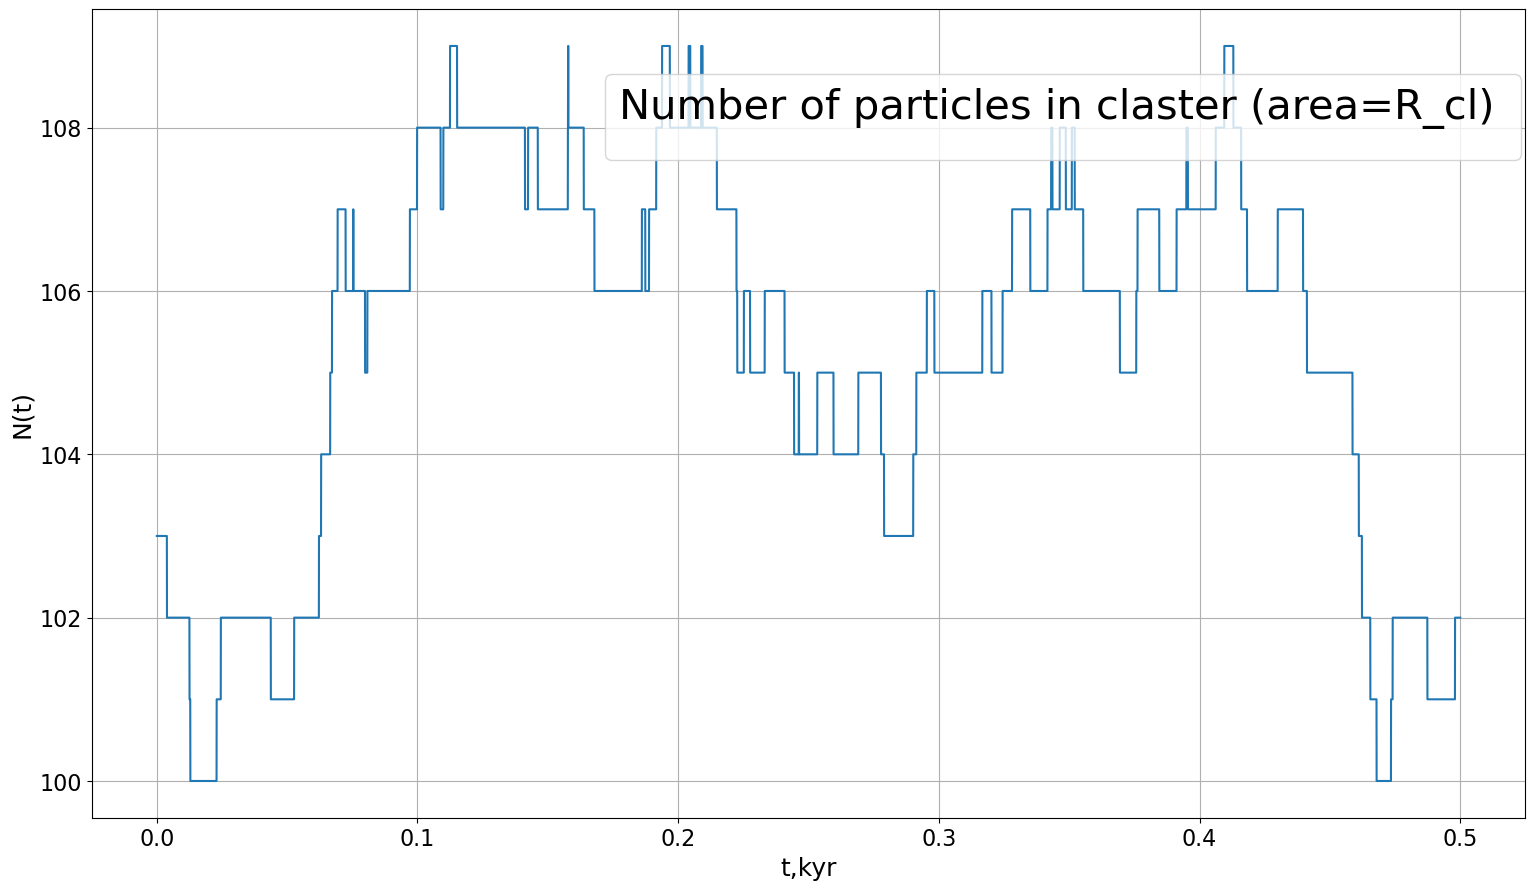

In [212]:
#plt.xlim([0, 1000000*dt])
#x=np.linspace(x_min, x_max, num=500)


fig3, ax3 = plt.subplots()

ax3.plot(t_ncl,NinS1,color="tab:blue")#,markevery=100,label="data"
#! ax3.plot(t_ncl,NinS2,color="orange")

#ax3.plot(t_ncl, func(t_ncl, *popt), 'r-',
#         label=f'fit poly(2): a={popt[0]:.2}, b={popt[1]:.2}, c={popt[2]:.2}',linewidth= 3 )
#ax3.plot(t_ncl[t_ncl<2*10**12], func2(t_ncl[t_ncl<2*10**12], *popt2), '--',color="orange",
#         label=f'fit poly(0): a={popt2[0]:.2f}, t<2e+12',linewidth= 3 )

#ax3.plot(x, np.exp(np.sin(x)), label="exp(sin(x))",color="r")
#ax3.plot(x,Lagr1(x,x1,y1), label="N_5",linestyle="dashed",color="g")#[Lagr1_old(i,x1,y1) for i in x])
#ax3.plot(x,Lagr1(x,x2,y2), label="N_6",linestyle="dashed",color="tab:blue")#[Lagr1_old(i,x2,y2) for i in x])

ax3.set(xlabel='t,kyr', ylabel='N(t)')
ax3.xaxis.label.set_fontsize(18)
ax3.yaxis.label.set_fontsize(18)
ax3.tick_params(labelsize=16)
ax3.grid(True)

#ax3.set_ylim(0, 5)
#ax3.set_xlim(0, 5*dt/10**(10))
fig3.set_size_inches(18.5, 10.5)
lines = []
labels = []

for ax3 in fig3.axes:
    axLine, axLabel = ax3.get_legend_handles_labels()
    lines.extend(axLine)
    
    labels.extend(axLabel)
fig3.legend( lines, labels,           
           loc = 'lower center',bbox_to_anchor=( 0.65 , 0.72 ),title = 'Number of particles in claster (area=R_cl) ', fontsize=25,title_fontsize=30)
           

#размер шрифта увеличить для значений осей
fig3 = ax3.get_figure()
fig3.savefig('Nt_graf.png')

plt.show()

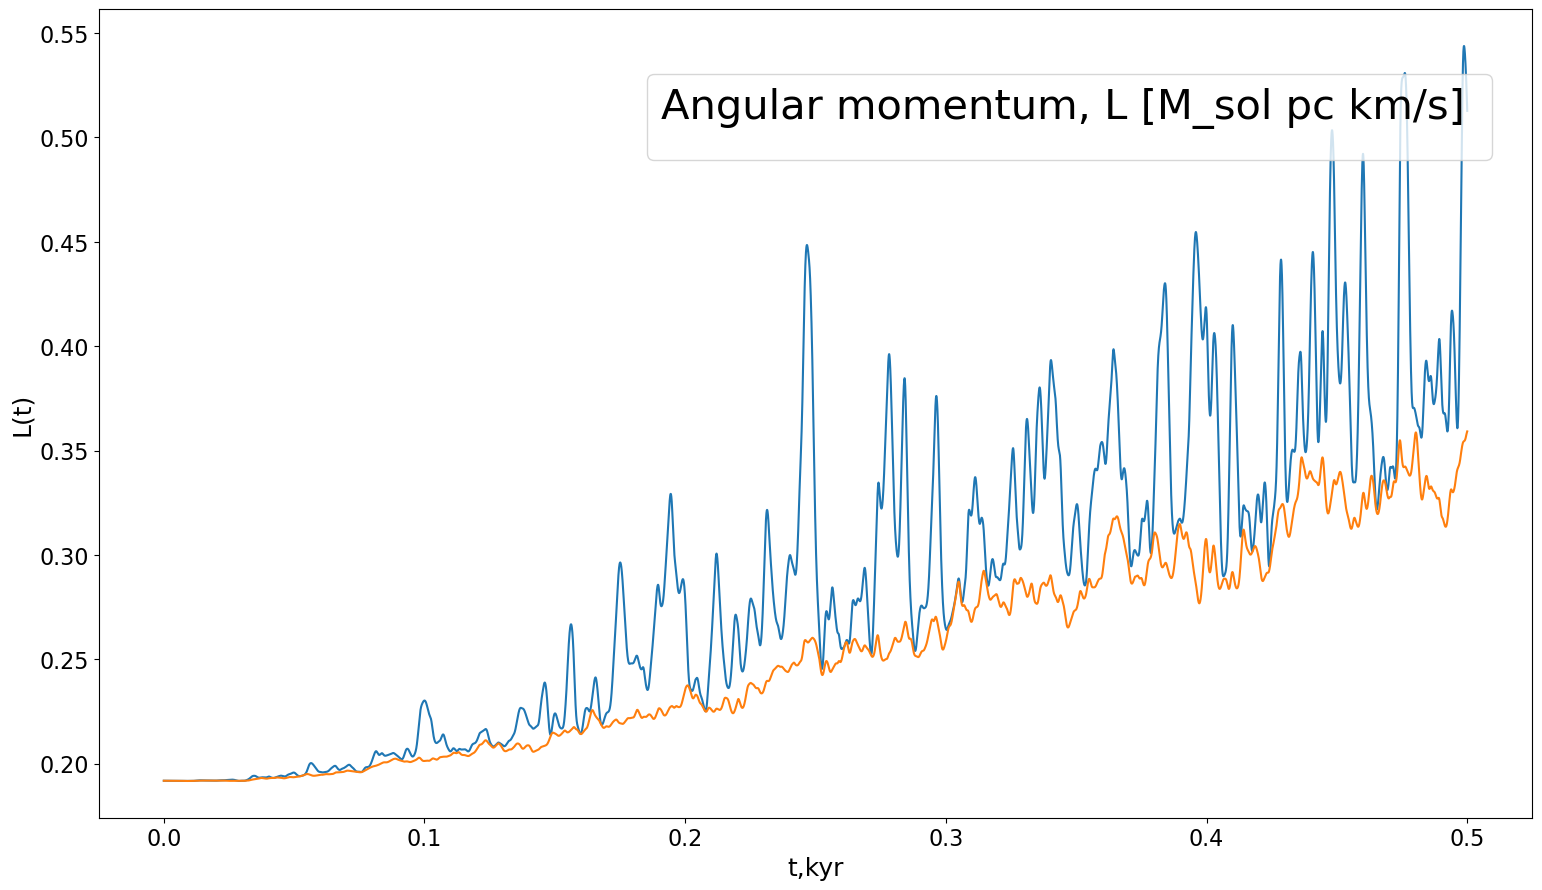

In [213]:
#plt.xlim([0, 1000000*dt])
#x=np.linspace(x_min, x_max, num=500)


figL, axL = plt.subplots()

axL.plot(t_ncl,Ltot1,color="tab:blue")#,markevery=100
axL.plot(t_ncl,Ltot2,color="tab:orange")

#axL.plot(t_ncl, func(t_ncl, *popt), 'r-', label=f'fit poly(2): a={popt[0]:.2}, b={popt[1]:.2}, c={popt[2]:.2}',linewidth= 3 )
#axL.plot(t_ncl[t_ncl<2*10**12], func2(t_ncl[t_ncl<2*10**12], *popt2), '--',color="orange", label=f'fit poly(0): a={popt2[0]:.2f}, t<2e+12',linewidth= 3 )

#ax3.plot(x, np.exp(np.sin(x)), label="exp(sin(x))",color="r")
#ax3.plot(x,Lagr1(x,x1,y1), label="N_5",linestyle="dashed",color="g")#[Lagr1_old(i,x1,y1) for i in x])
#ax3.plot(x,Lagr1(x,x2,y2), label="N_6",linestyle="dashed",color="tab:blue")#[Lagr1_old(i,x2,y2) for i in x])

axL.set(xlabel='t,kyr', ylabel='L(t)')
axL.xaxis.label.set_fontsize(18)
axL.yaxis.label.set_fontsize(18)
axL.tick_params(labelsize=16)
#axL.grid(True)
#ax3.set_ylim(1, 3);
figL.set_size_inches(18.5, 10.5)
lines = []
labels = []

for axL in figL.axes:
    axLine, axLabel = axL.get_legend_handles_labels()
    lines.extend(axLine)
    
    labels.extend(axLabel)
figL.legend( lines, labels,           
           loc = 'lower center',bbox_to_anchor=( 0.65 , 0.72 ),title = 'Angular momentum, L [M_sol pc km/s] ', fontsize=25,title_fontsize=30)
           

#размер шрифта увеличить для значений осей
figL = axL.get_figure()
figL.savefig('Lt_graf.png')

plt.show()

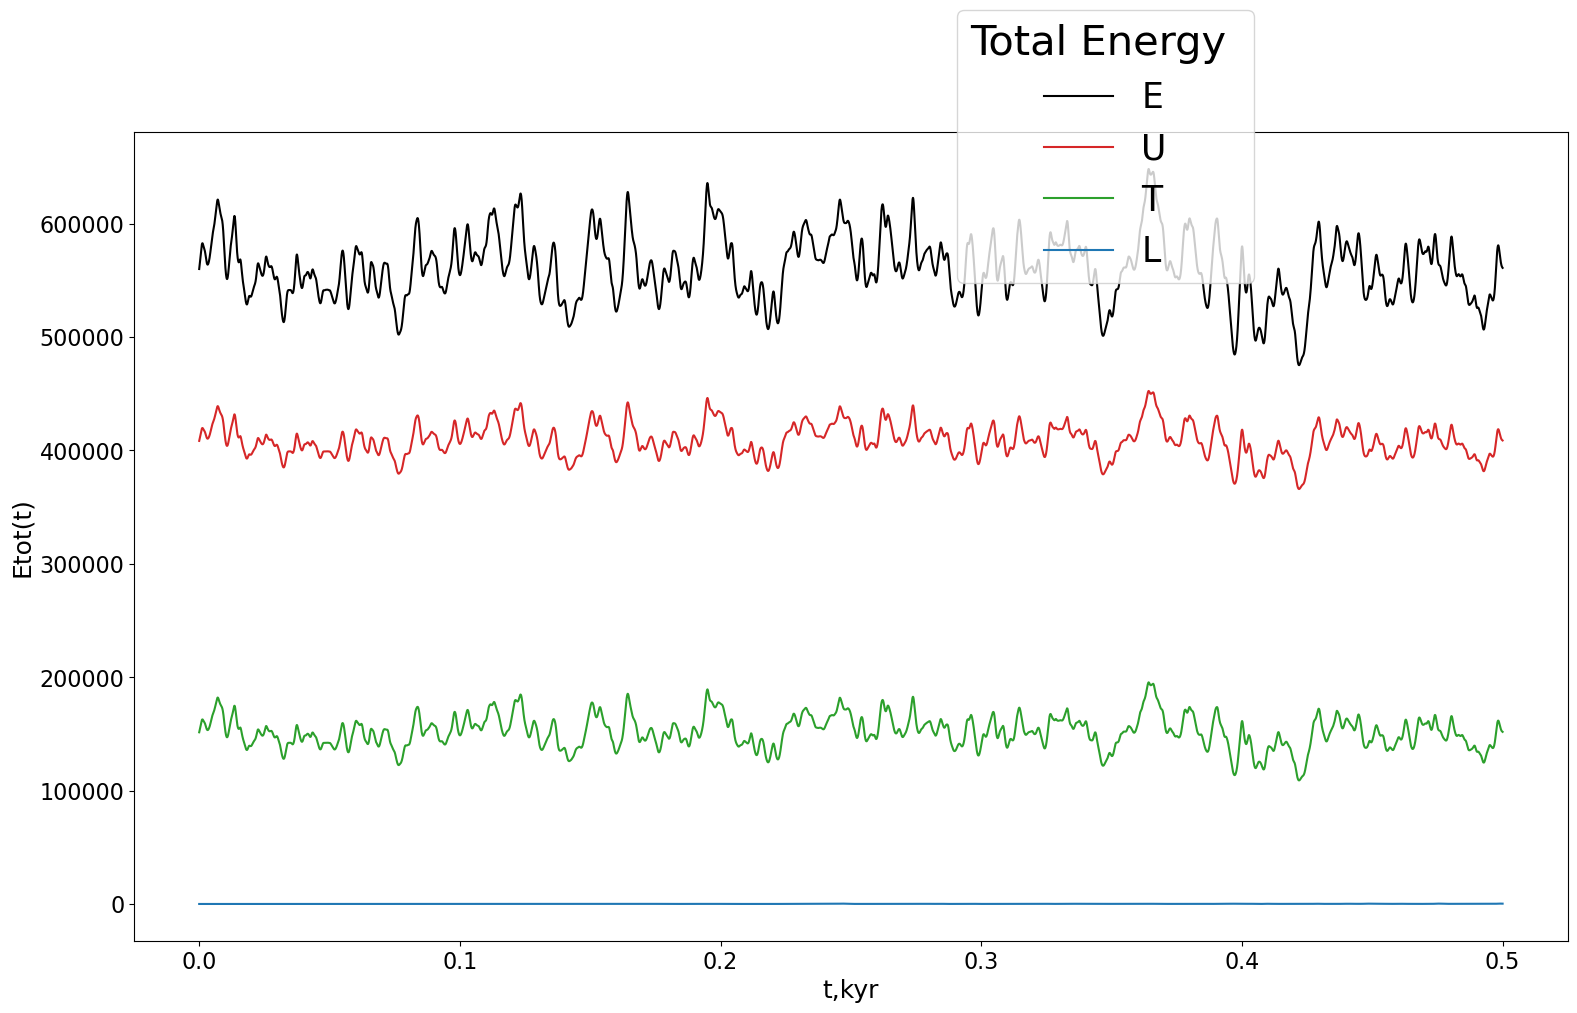

In [214]:
#plt.xlim([0, 1000000*dt])
#x=np.linspace(x_min, x_max, num=500)


figE, axE = plt.subplots()

axE.plot(t_ncl,np.sum(E1_save,axis=1),color="black",label="E")#,markevery=100
#! axE.plot(t_ncl,E2_save,color="tab:orange")

axE.plot(t_ncl,E1_save[:,0],color="tab:red",label="U")
axE.plot(t_ncl,E1_save[:,1],color="tab:green",label="T")
axE.plot(t_ncl,E1_save[:,2],color="tab:blue",label="L")

axE.set(xlabel='t,kyr', ylabel='Etot(t)')
axE.xaxis.label.set_fontsize(18)
axE.yaxis.label.set_fontsize(18)
axE.tick_params(labelsize=16)
#axL.grid(True)
#ax3.set_ylim(1, 3);
figE.set_size_inches(18.5, 10.5)
lines = []
labels = []

for axE in figE.axes:
    axLine, axLabel = axE.get_legend_handles_labels()
    lines.extend(axLine)
    
    labels.extend(axLabel)
figE.legend( lines, labels,           
           loc = 'lower center',bbox_to_anchor=( 0.65 , 0.72 ),title = 'Total Energy ', fontsize=25,title_fontsize=30)
           

#размер шрифта увеличить для значений осей
figE = axE.get_figure()
figE.savefig('Et_graf.png')

plt.show()

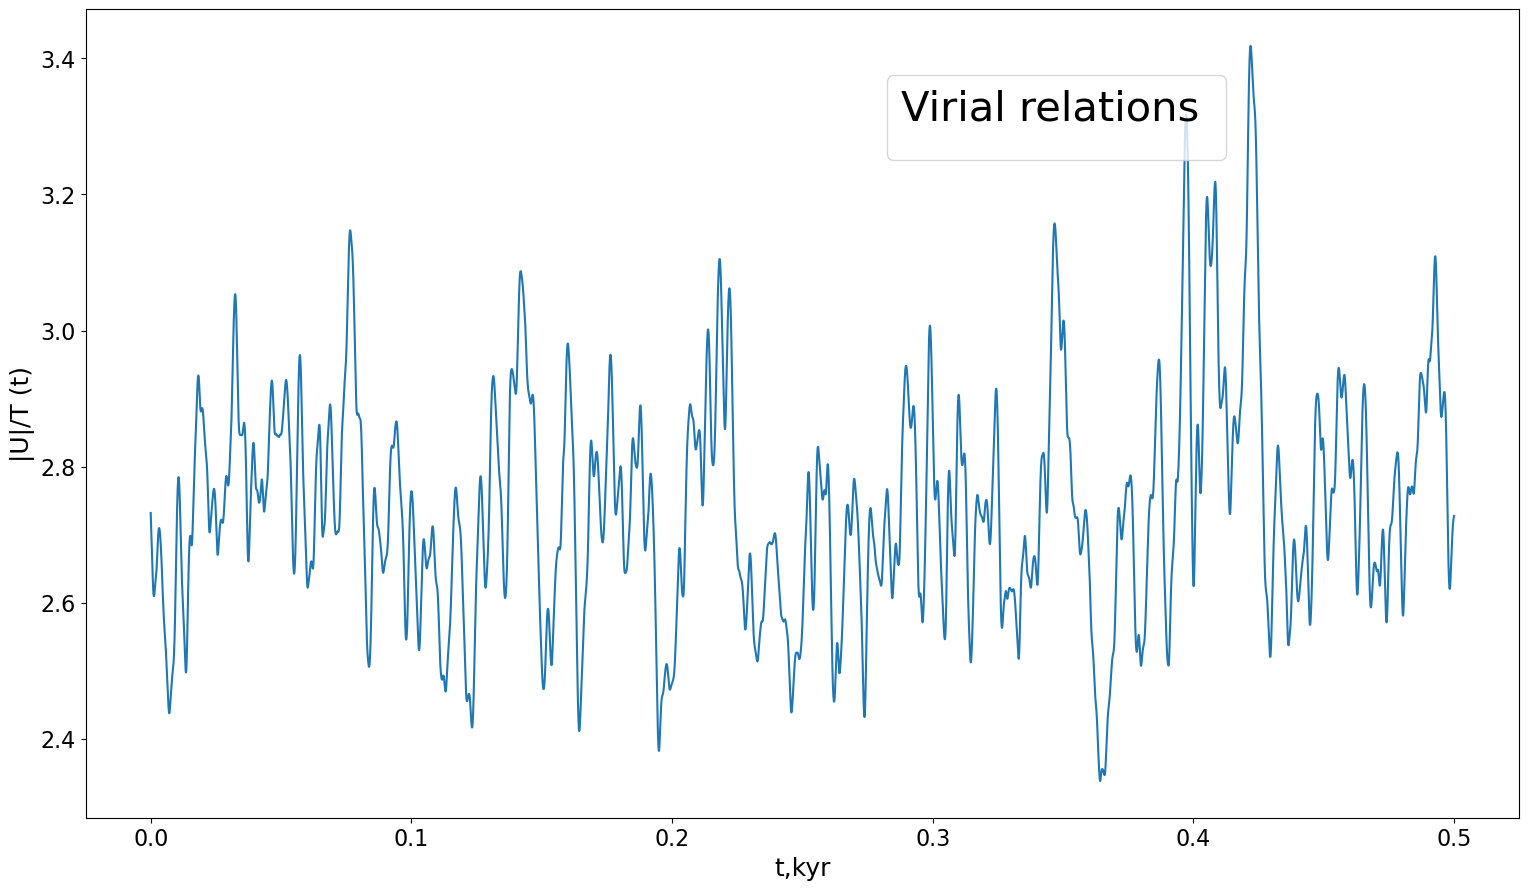

In [215]:
#plt.xlim([0, 1000000*dt])
#x=np.linspace(x_min, x_max, num=500)


figV, axV = plt.subplots()

axV.plot(t_ncl,Vir1_save,color="tab:blue")#,markevery=100
#! axV.plot(t_ncl,Vir2_save,color="tab:orange")

axV.set(xlabel='t,kyr', ylabel='|U|/T (t)')
axV.xaxis.label.set_fontsize(18)
axV.yaxis.label.set_fontsize(18)
axV.tick_params(labelsize=16)
#axL.grid(True)
#ax3.set_ylim(1, 3);
figV.set_size_inches(18.5, 10.5)
lines = []
labels = []

for axV in figV.axes:
    axLine, axLabel = axV.get_legend_handles_labels()
    lines.extend(axLine)
    
    labels.extend(axLabel)
figV.legend( lines, labels,           
           loc = 'lower center',bbox_to_anchor=( 0.65 , 0.72 ),title = 'Virial relations ', fontsize=25,title_fontsize=30)
           

#размер шрифта увеличить для значений осей
figV = axV.get_figure()
figV.savefig('Vt_graf.png')

plt.show()

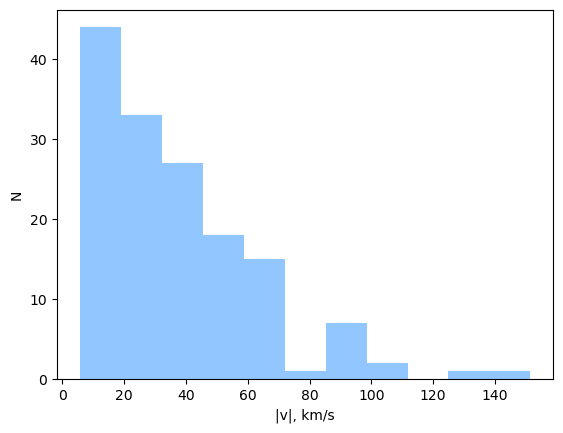

In [216]:
plt.hist(np.sqrt(np.sum(vel**2,axis=1)),bins=11)
plt.xlabel("|v|, km/s")
plt.ylabel("N")
#plt.savefig("vel_2.png")
plt.show()

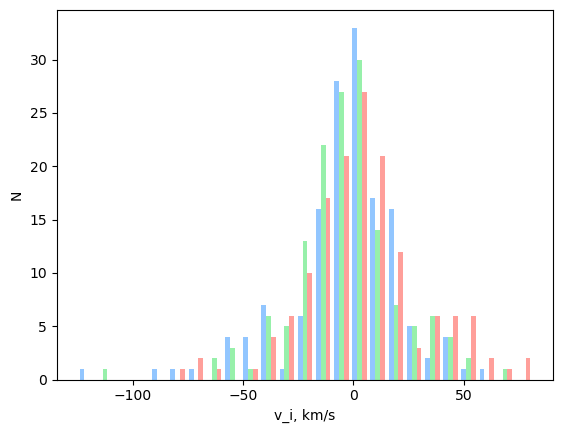

In [217]:
plt.hist(vel,bins=25)
plt.xlabel("v_i, km/s")
plt.ylabel("N")

#plt.savefig("vel_22.png")
plt.show()

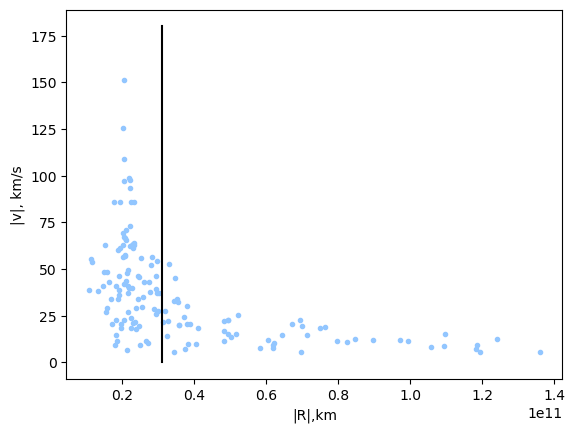

In [218]:
plrv=np.array([np.sqrt(np.sum(pos[:,:]**2,axis=1)),np.sqrt(np.sum(vel[:,:]**2,axis=1))])
plt.plot(plrv[0],plrv[1],".")
plt.plot(R_cl*np.ones(10),np.arange(0,200,20),color="black")
plt.ylabel("|v|, km/s")
plt.xlabel("|R|,km")
#plt.savefig("VR2.png")
plt.show()

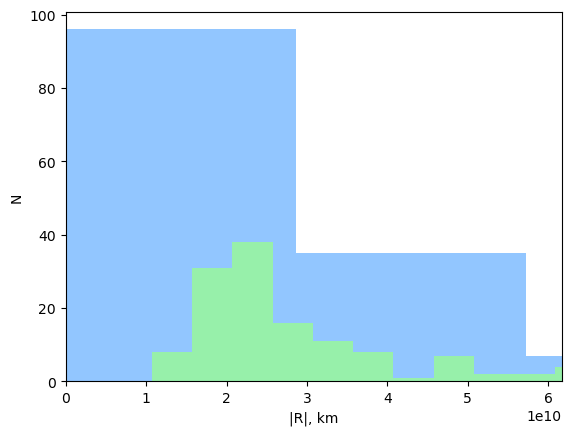

In [219]:
plt.hist(np.sqrt(np.sum(pos_save[:,:,0]**2,axis=1)),bins=5)
#plt.hist(np.sqrt(np.sum(pos_save[:,:,50000]**2,axis=1)),bins=10)
plt.hist(np.sqrt(np.sum(pos**2,axis=1)),bins=25)
plt.xlim(0,2*R_cl)
plt.xlabel("|R|, km")
plt.ylabel("N")
#plt.savefig("vel_2.png")
plt.show()

In [194]:
#in_cl=np.where(np.sum((pos-pos[-1,:])**2,axis=1)>(R_cl)**2)
#pos_in_cl=np.delete(pos-pos[-1,:], in_cl, axis = 0)
#mass_in_cl=np.delete(mass, in_cl, axis = 0)
#vel_save=np.delete(vel, in_cl, axis = 0)
#np.savez_compressed('IC_100N101dte5add100_002', pos=pos_in_cl, vel=vel_save, mass=mass_in_cl)